# 制作数据集

In [1]:
# 采集右半屏区域 去除背景后的手势
import cv2
from fastai.vision import *

def backgroudRemove():
    # 开启电脑上摄像头进行实时预测
    cap = cv2.VideoCapture(0)
    tot = 1
    bs = cv2.createBackgroundSubtractorKNN(detectShadows=True)
    # 循环使用cv2的read()方法读取视频帧
    while 1:
        ret, frame = cap.read()
        if ret:
            img = bs.apply(frame)
            cap_region_x_begin = 0.5  # start point/total width
            cap_region_y_end = 1  # start point/total width

            img = img[0:int(cap_region_y_end * img.shape[0]),
                  0:int(cap_region_x_begin * img.shape[1])]  # clip the ROI
            img = cv2.flip(img, 1)  # flip the frame horizontally
        
            cv2.imwrite('image/' + str(tot) + '.jpg', img)
            cv2.imshow('frame2', img)
            k = cv2.waitKey(1) & 0xff
            if k == 27:
                break
        else:
            break
        tot += 1
        # print('tot=', tot)
    cap.release()
    cv2.destroyAllWindows()
    
backgroudRemove()

# 训练模型

In [111]:
from fastai.vision import *
np.random.seed(42)
path = pathlib.Path('image')
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=64, num_workers=0).normalize(imagenet_stats)# size的设置不超过224，不然内存不够
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [112]:
data.classes

['-1', '0', '1', '2', '3', '4', '5']

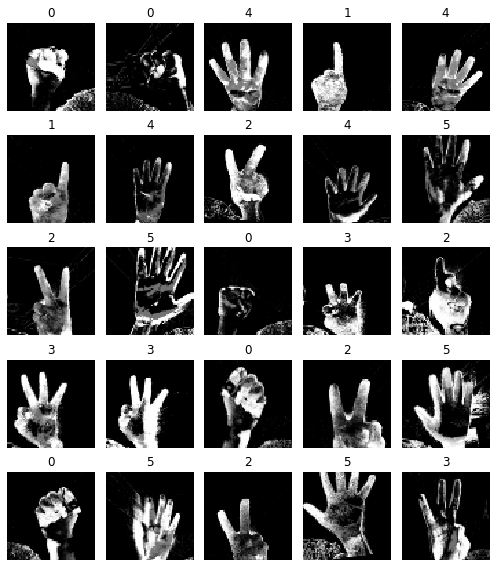

In [113]:
#展示了前几张图片
data.show_batch(rows=5, figsize=(7,8))

In [114]:
# 查看分类 、训练集 、 验证集的数量
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['-1', '0', '1', '2', '3', '4', '5'], 7, 5580, 1395)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


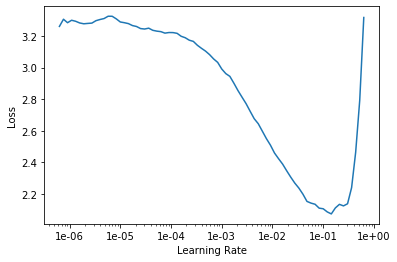

In [115]:
# 然后我们运行学习率查找方法，把它的结果画出来（它会告诉你输入什么代码来画出结果）。我们看下这个图。
learn.lr_find()
learn.recorder.plot()

In [116]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.130218,0.633733,0.175627,02:42
1,0.929264,0.457150,0.109677,02:14
2,0.955854,0.399812,0.064516,02:13
3,0.923232,0.373763,0.048029,02:15
4,0.815972,0.573790,0.047312,02:14
5,0.607525,0.157719,0.026523,02:13
6,0.428237,0.147406,0.029391,02:13
7,0.241047,0.069028,0.017921,02:16
8,0.172414,0.054913,0.016487,02:17
9,0.140598,0.084989,0.016487,02:13


In [117]:
# 我喜欢把开始的结果保存下来，res34 size224
name = '3-binary_7_7000_10times-res34-0164'
learn.save(name)

In [28]:
# 然后我们运行学习率查找方法，把它的结果画出来（它会告诉你输入什么代码来画出结果）。我们看下这个图。
learn.load(name);

# 解读结果

In [64]:
#像以前一样，我们可以使用ClassificationInterpretation类型来看看结果。
learn.load(name);

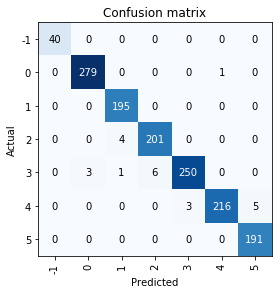

In [118]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Putting your model in production 部署模型¶

In [119]:
# 首先将模型导出：
#这会在目录中创建一个名为export.pkl的文件，它包含了部署模型所需要的所有内容（模型，权重以及一些元数据）
learn.export()

In [379]:
#export.pkl，然后我们在生产环境中创建学习器：
learn = load_learner(path)

In [110]:
# path = 'test4_binary/3/3_frame_001236.jpg'
path = 'img_cut/-1_73.jpg'
img =  open_image(path)
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category -1

# 开始预测

In [1]:
import cv2
from fastai.vision import *

def backgroudRemove(imgpath):
    # 加载本地视频进行预测
    cap = cv2.VideoCapture(imgpath)
    # 开启电脑上摄像头进行实时预测
#     cap = cv2.VideoCapture(0)
    bs = cv2.createBackgroundSubtractorKNN(detectShadows=True)
    tot = 1
    # 读取训练的模型进行预测
    learn = load_learner('image')
    #设置起始预测值为 -1
    preNum = -1

    # 循环使用cv2的read()方法读取视频帧
    while 1:

        ret, frame = cap.read()
        if ret:
         
            frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            img = bs.apply(frame)
            
            # 尝试 优化 ——将背景图与原图进行与运算后再进行预测，效果无明显变化
#             binary = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
#             bitwiseAnd = cv2.bitwise_and(binary, img)
#             cv2.imshow('frame2', bitwiseAnd)
            cap_region_x_begin = 0.5  # start point/total width
            cap_region_y_end = 1  # start point/total width

            img = img[0:int(cap_region_y_end * img.shape[0]),
                  0:int(cap_region_x_begin * img.shape[1])]  # clip the ROI
            img = cv2.flip(img, 1)  # flip the frame horizontally
            # cv2.imshow('frame1', img)

            img_fastai = Image(pil2tensor(img, dtype=np.float32).div_(255))
            pred_class, pred_idx, outputs = learn.predict(img_fastai)
            preNum = pred_class
            
            # 将预测结果保存下来进行查看或者作为数据集添加数据
            # cv2.imwrite('D:/py/10.0-2.13-opencv/jupyter-notebook/work1_hand_reg/img_cut/' +str(a)+'_'+ str(tot) + '.jpg', img)
         
            cv2.putText(img, str(preNum), (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 10, cv2.LINE_AA)
            cv2.imshow('frame2', img)
            k = cv2.waitKey(1) & 0xff
            if k == 27:
                break
        else:
            break
        # tot += 1
        # print('predict=', str(preNum))
        # print('tot=', tot)
    cap.release()
    cv2.destroyAllWindows()


imgpath = 'D:/py/10.0-2.13-opencv/jupyter-notebook/work1_hand_reg/video/demo3.mp4'
backgroudRemove(imgpath)


UnboundLocalError: local variable 'temp' referenced before assignment